# Introduction

Fred Etter - March 2019  

This notebook uses data from a Kaggle competition to predict if a customer will buy a product from Banco Santander during a typical transaction.  There are a total of 200,000 rows of customer transactions along with the binary outcome of whether they made a purchase or not.  There are 200 columns, or 200 features, to use as inputs to each of the models that are presented.  

The workflow in this notebook is as follows:
1.  Import and Clean Data  
2.  Data Exploration  
3.  Modeling and Evaluation
4.  Conclusion and Discussion  


In [1]:
# Import necessary modules
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1.  Import and clean the data  
In this section, the data is imported and cleaned.  

Import the data from a csv file; then print the number of rows and columns of the data; then show the first 5 lines of the dataframe.

In [2]:
df = pd.read_csv(r"C:\Users\Fred\Documents\PythonDirectory\Unit 3\train_san.csv")
print(df.shape)
df.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


There are 200,000 rows and 202 columns.  All of the feature data are float numbers.  We can drop the ID_code later because it is irrevelant.  The var_1, var_2, etc are the column names given in the orginal dataset.  These features have not been specifically defined in Kaggle.  They are anonymized features that have been captured during customer transactions.  

Next, we'll print the sum of the 'target' column which is the number of all of the rows where the customer bought a product.  Then we calculate the buy ratio.  As you can see here, a customer bought something about 10% of the time.

In [3]:
df['target'].sum()


20098

In [4]:
# print the sume of the target column
df['target'].sum()

# divide the target sum by the total number of rows
print("Customers average buy ratio, {}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.10049


Now we know we have a highly imbalanced dataset; 10% are 'buy' transactions, 90% are 'not buy' transactions.  In order to capture this imbalance we will use following technique:
- we will randomly remove most of the 'not buy' rows so the number of 'buy' and 'not buy' rows are even.  

Next, let's look at some of the data types in our dataset and check for NaN values.

In [5]:
df.dtypes.head()

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
dtype: object

We see that the 'target' data type is an integer which is what we'll need for the machine learning algorithms.  We have float values for the columns - which is what we want - and an 'ID_code' that is an object (we'll delete this column later).

In [6]:
df.isnull().sum().sum()

0

Perfect, no cleaning necessary for NaN values.

Drop the ID_code column since it is a string and irrelevant to making a buy or no_buy prediction.  Also, drop a random sample of 140,000 rows to account for hardware / memory limitations.

In [7]:
# drop ID_code column
df.drop(['ID_code'], axis=1, inplace=True)

# drop a random sample of 140,000 rows
df.drop(df.sample(140000).index, inplace=True)

Look at the number of rows of the data to make sure we dropped correct amount and then shuffle the data randomly to prepare data for modeling.

In [8]:
print(df.shape[0])
df = df.sample(frac=1)

60000


Take another look at the data to see random shuffled rows.

In [9]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
153279,0,13.4598,-4.9446,13.8942,3.8161,11.3192,6.0276,5.3160,11.9087,-0.0202,...,3.9195,8.7725,3.6793,8.6039,18.2388,-1.3333,-4.6292,9.0151,11.1439,4.1512
120582,0,13.3489,3.8267,10.8418,8.4086,12.0988,1.6460,4.4191,18.3793,-3.1492,...,11.0486,9.1517,1.3193,11.9975,14.6186,0.1950,0.4004,8.4924,17.9153,-31.2632
96017,0,6.7882,0.0041,8.7193,8.0160,12.9701,-7.8830,5.2938,17.6484,-3.4791,...,-1.6389,8.6509,3.4810,4.5539,11.5148,0.7444,-2.6491,7.9733,12.2986,-1.4185
146320,0,9.0245,2.6627,9.9321,5.8133,11.9929,7.2106,5.6560,16.7814,-1.6673,...,0.4301,9.7868,3.6325,-1.6695,12.1542,-1.0946,4.0017,8.4651,20.0559,-20.3015
190682,0,13.7817,0.8316,7.7744,6.7931,12.6074,-2.0041,5.3729,16.7302,-0.4279,...,4.2199,1.6616,1.4634,3.7467,16.3199,-1.8213,9.2301,8.8300,12.7291,-5.9074


At this point our data looks clean and ready to start exploring in more detail to look for features that might be better predictors for the target data.  We can use the pairplot and the heatmap functionality to begin this analysis.

# 2.  Data Exploration  
First, let's look at the correlation between the target and the features. 

In [10]:
# use absolute value
np.absolute(df.corr().unstack().sort_values().drop_duplicates())[:10]

var_81   target    0.088975
var_139  target    0.071937
target   var_12    0.068316
var_146  target    0.062869
target   var_76    0.061716
var_166  target    0.061479
target   var_80    0.060312
var_174  target    0.059662
var_109  target    0.055550
target   var_34    0.055452
dtype: float64

There aren't any strongly correlated features in this dataset.  The highest correlation is only around 9%.


Next, we'll look at the pairplot for the top 10 features as determined by the correlations found in the previous step.

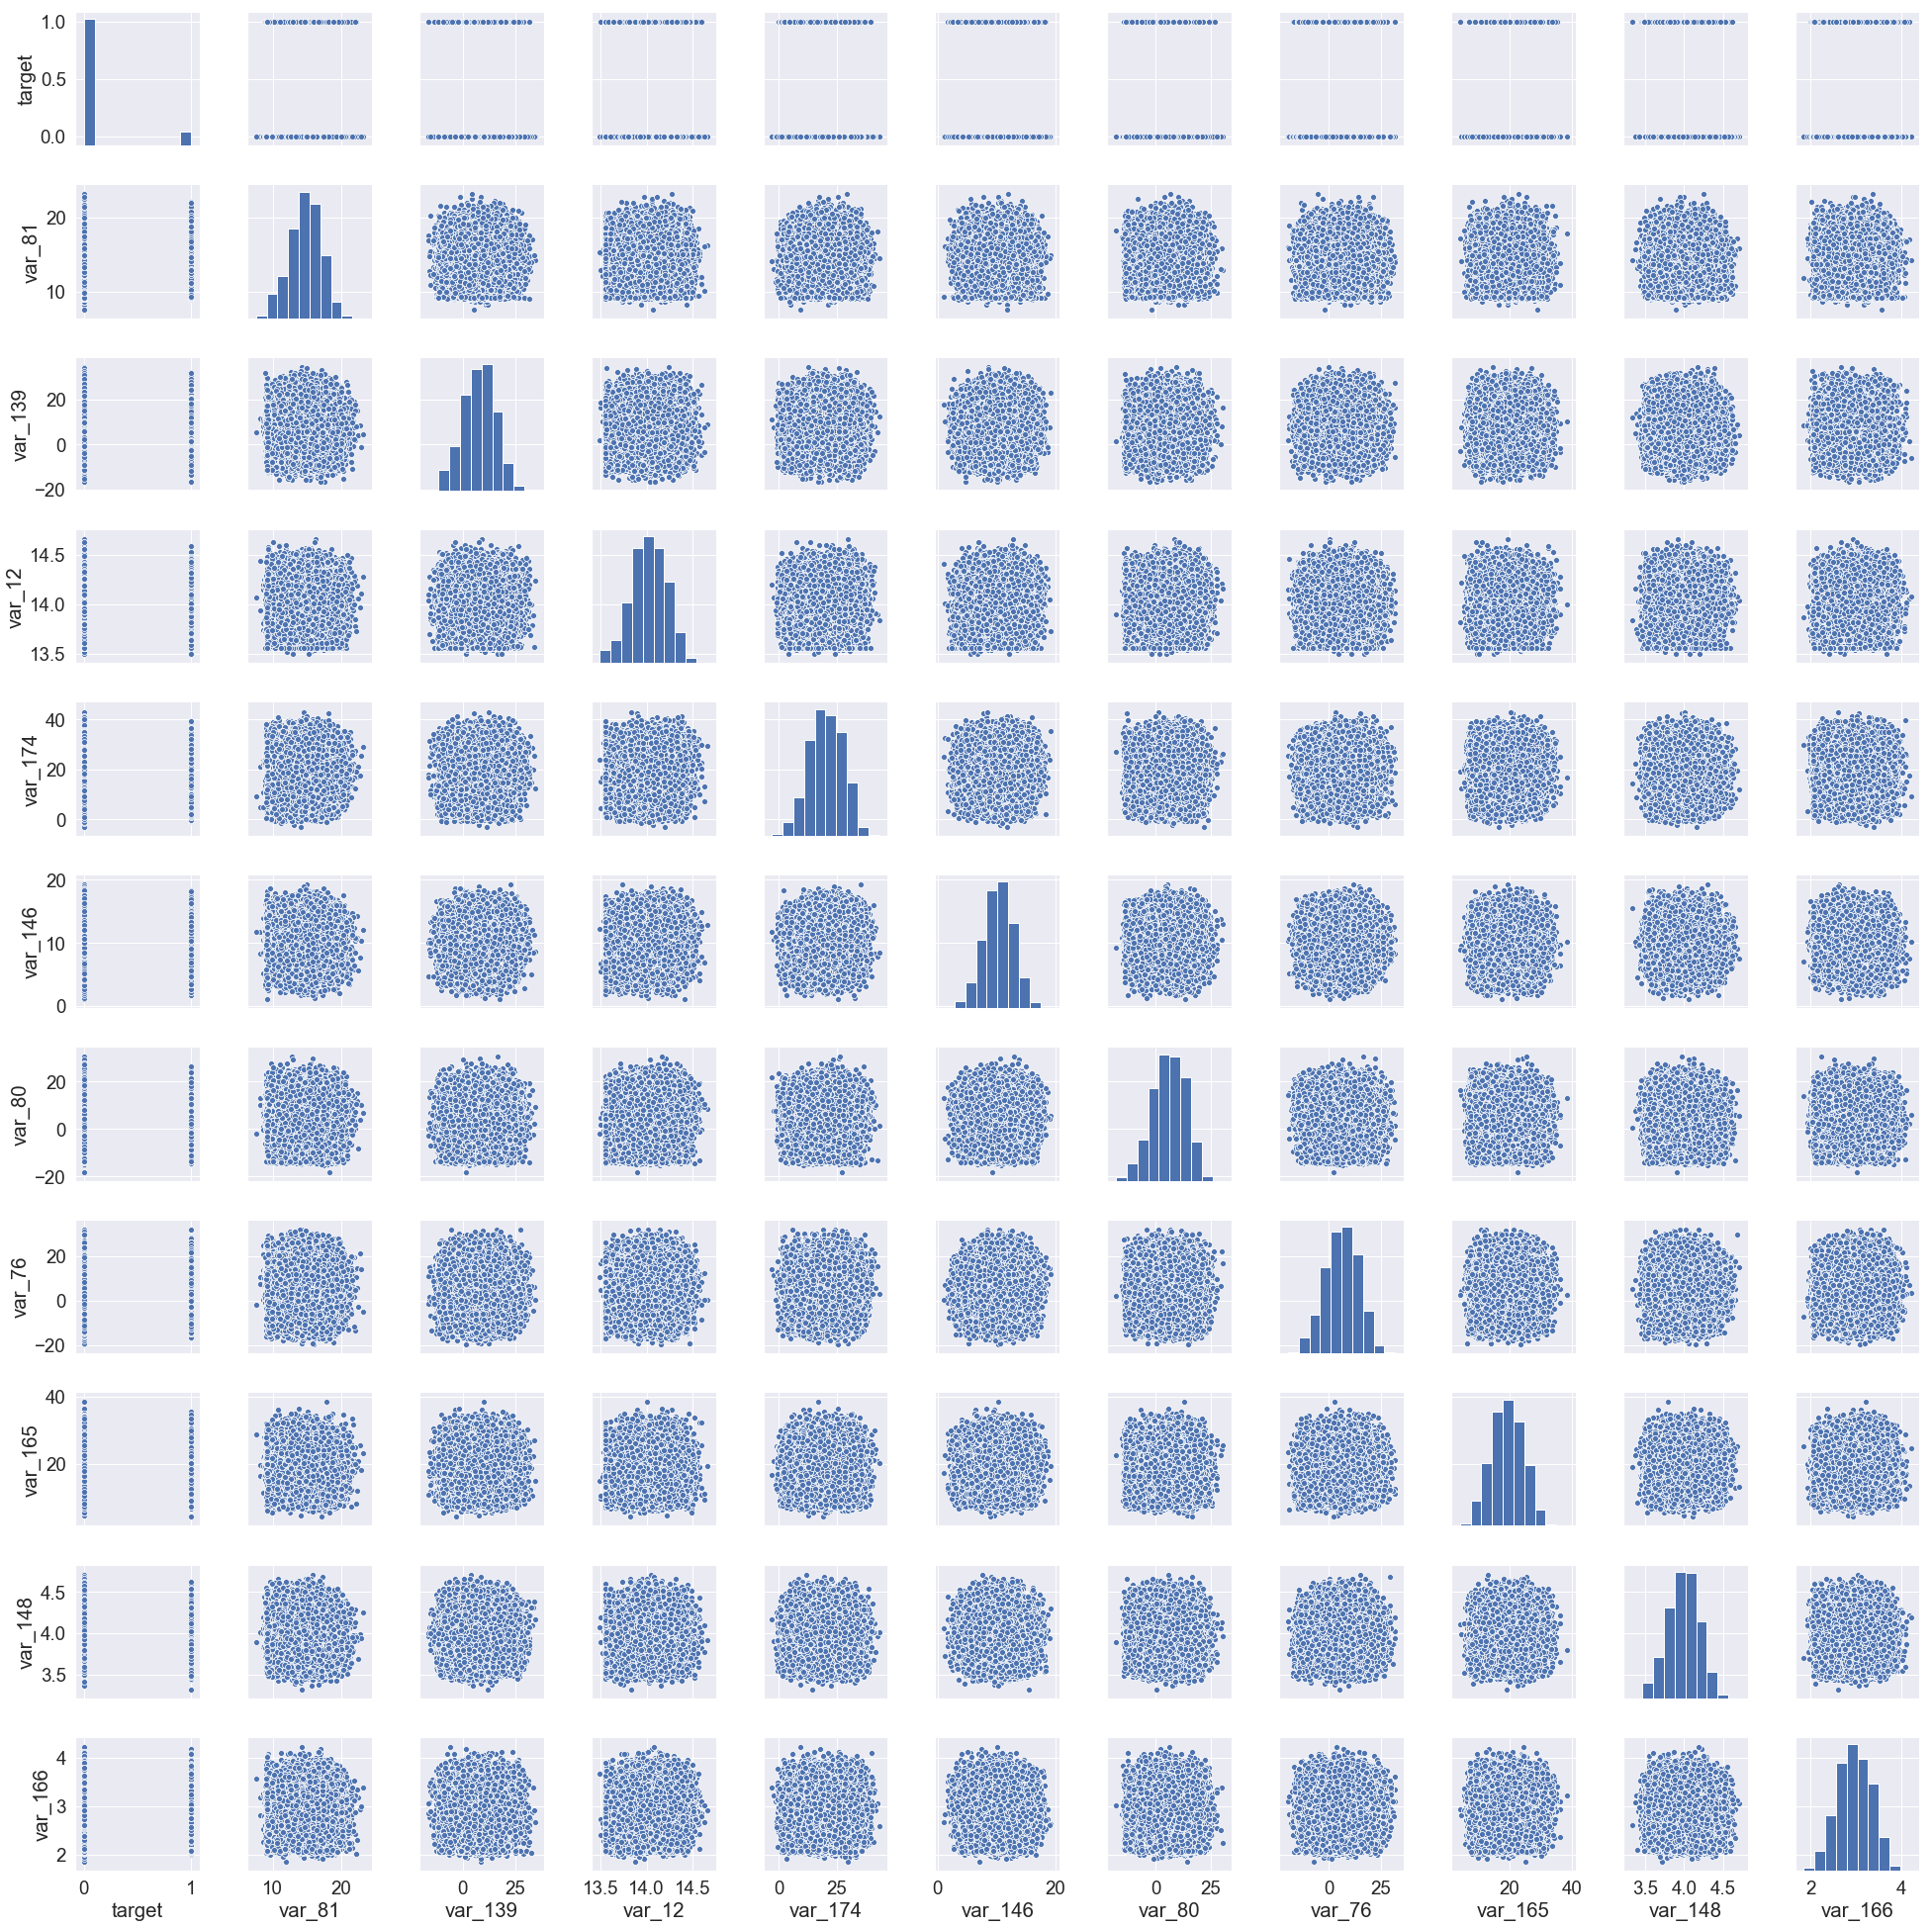

In [11]:
df_pp = df[['target', 'var_81', 'var_139', 'var_12', 'var_174', 
            'var_146', 'var_80', 'var_76', 'var_165', 'var_148', 'var_166']].copy()

sns.set(font_scale=1.7)
sns.pairplot(df_pp)
plt.show()

Nothing too exciting here; looks like a lot of noise.  Features look highly uncorrelated.  We do see that all of these features are very close to normally distributed.  We can also see the previously observed ratio of 1 buy transaction for every 10 transations.  

We can look at a heatmap for the 10 best features (determined above) for a more visual representation of the correlations between target and feature data.

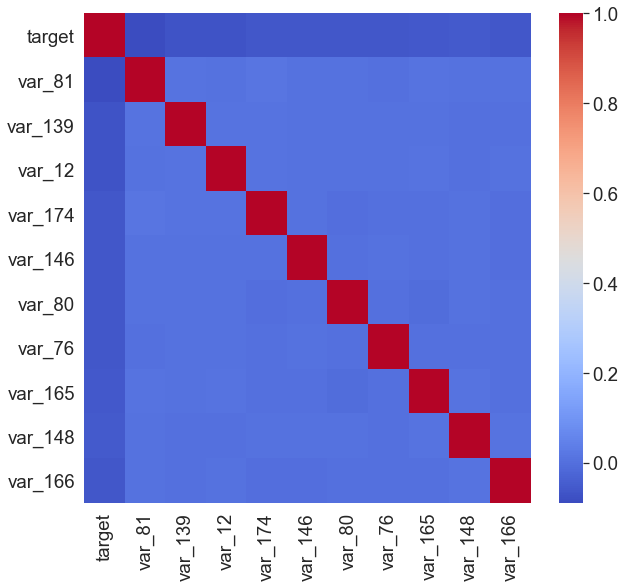

In [12]:
import seaborn as sns
plt.figure(figsize=(10,9))
corr = df_pp.corr()
sns.heatmap(corr, cmap='coolwarm')
plt.savefig('heatmat.png')

The above heatmap and correlation values show that there is very little correlation between the target variable and the top 10 best predictive features.  It looks like, at this point, we will need to incorporate many features (maybe most of the 200) to improve the predictive value of each model.

# 3.  Build the models and evaluate
The first step to building a good model is to separate the data into training and test data.  We'll train the model on the training data and test it with the test data.  This next line of code breaks the dataframe into 2 dataframes: 1 for training and 1 for test.

In [13]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

Confirm the new shapes of the 2 new dataframes.

In [14]:
df_train.shape

(48000, 201)

In [15]:
df_test.shape

(12000, 201)

Again, confirm the existence of about 10% 'buy' rows for the training data. (8034 is about 10% of 80,000 from above)

In [16]:
print("Customers average buy ratio, {0:.3f}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.100


Next, we need to balance the data to account for the current 9 to 1 ratio of 'not buy' to 'buy'.  In this case, dropping around 90% of the zeros was performed to ....

In [17]:
# set variable buy_num to the total number of buys
buy_num = df_train['target'].sum()
print(buy_num)

# calculate the difference between the total rows and the number of buys
diff = df_train.shape[0] - buy_num

# calculate the number of rows to drop and drop those rows
df_train.drop(df_train.query('target < 1').sample(frac=(1 - (buy_num/diff))).index, inplace=True)
print(df_train.shape)

4814
(9628, 201)


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Confirm the new shape of the training data.  The new training dataframe has an equal number of 'buy' and 'not buy' rows.  As you can see, the number of rows has twice the number of the number of 'buys' in the dataframe.

In [18]:
print("Number of buys, {}".format(buy_num))
print("Number of rows and columns, {}".format(df_train.shape))

Number of buys, 4814
Number of rows and columns, (9628, 201)


We will use the Area Under the ROC curve insead of the more typical r-squared accuracy measure.  This is the preferred metric in accordance with Kaggle scoring.

Basic Logistic Regression is the first model used to calculate the ROC accuracy.  

#### 3.1  Logistic Regression

In [19]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LogisticRegression(solver='sag')

# set features and dependent variable for training data
y_train = df_train['target'].values

# drop the 'target' column to obtain the feature inputs
df_train.drop(['target'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['target'].values

# drop the 'target' column to obtain the feature inputs
df_test.drop(['target'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



Duration: 0:00:01.039060


Calculating the are under the ROC curve next for the Linear Regression Model.

In [20]:
from sklearn import metrics
y_test_pred = regr.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7421006271171581

Computing the Confusion Matrix for the LR Model.

In [21]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)
# print(len(y_test), np.sum(y_test))

array([[8119, 2667],
       [ 326,  888]], dtype=int64)

Computing the raw accuracy for the LR Model.

In [22]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7505833333333334

**Evaluation**:  ROC score = 0.742.  Confusion Matrix (raw) accruacy = 0.751 (This is calculated by adding the true positive and true negative values of 8081 and 869 and dividing by the total count of 12,000).  We need to remember that the floor predictive value is 0.50 since we know that there only 2 possible outcomes, 0 or 1.  This is a good start; let's see if we can improve upon these accuracy measures.  

#### 3.2  Extra Trees Classifier

In [23]:
# 2.  Extra Trees Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import ExtraTreesClassifier

# Instantiate our model.
etc = ExtraTreesClassifier(n_estimators=500)

# fit model to data
etc.fit(x_train, y_train)

from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:24.400396


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Extra Trees Classifier.

In [24]:
from sklearn import metrics
y_test_pred = etc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7612689553332146

In [25]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8648, 2138],
       [ 339,  875]], dtype=int64)

In [26]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7935833333333333

**Evaluation**:  Scores are a little better.  From sklearn: Extra Trees - "An extremely randomized tree classifier."

"Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen. When max_features is set 1, this amounts to building a totally random decision tree."  

#### 3.3  Random Forest Classifier

In [27]:
# 3.  Random Forest Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc = RandomForestClassifier(n_estimators=500)

# fit model to data
rfc.fit(x_train, y_train)

#------------------------------------------------------------------------------
sfm = SelectFromModel(rfc, threshold=0.001, max_features=10)
sfm.fit(x_train, y_train)
sfm.get_support()
selected_feat = df_train.columns[(sfm.get_support())]
len(selected_feat)
print(selected_feat)
#selected_feat(sfm.estimator_, feature_importances_).ravel().hist()
#------------------------------------------------------------------------------

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Index(['var_6', 'var_22', 'var_26', 'var_81', 'var_99', 'var_109', 'var_110',
       'var_139', 'var_146', 'var_174'],
      dtype='object')

Duration: 0:03:11.268940


Printing the most important features as determined by the random forest algorithm.

In [28]:
print((feature_importances).head(10))

         importance
var_81     0.018784
var_110    0.011734
var_139    0.011104
var_26     0.010598
var_6      0.010289
var_99     0.010064
var_109    0.009675
var_174    0.009018
var_146    0.008566
var_53     0.008477


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for Random Forest Classifier.

In [29]:
from sklearn import metrics
y_test_pred = rfc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7522153313023074

In [30]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8044, 2742],
       [ 293,  921]], dtype=int64)

In [31]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7470833333333333

**Evaluation**:  Performance is not quite as strong as Extra Trees.  Since a there are so many features and none have a high correlation with the target, we need a lot of 'weak' predictions and then average those to form the final prediction score.

#### 3.4  Gradient Boosting Classifier

In [32]:
# 4.  Gradient Boosting Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:02:16.629814


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Gradient Boosting Classifier.

In [33]:
from sklearn import metrics
y_test_pred = gbc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7723731812945637

In [34]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8621, 2165],
       [ 309,  905]], dtype=int64)

In [35]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7938333333333333

**Evaluation**:  All scores are still a little better than the previous.  

The following gradient boosting algorithm is used with just the 10 best features (from Random Forest 'feature_selections_').  

#### 3.5  Gradient Boosting with 10 best features

In [36]:
# 5.  GBC with just the 10 best features (n_estimators=500)

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_10 = GradientBoostingClassifier(n_estimators=500)

x_train_10 = sklearn.preprocessing.normalize(df_train[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                    'var_110', 'var_139', 'var_146']])

x_test_10 = sklearn.preprocessing.normalize(df_test[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                                              'var_110', 'var_139', 'var_146']])

# fit model to data
gbc_10.fit(x_train_10, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:07.915453


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Gradient Boosting Classifier with 10 best features.

In [37]:
from sklearn import metrics
y_test_pred = gbc_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6371653443004247

In [38]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7268, 3518],
       [ 485,  729]], dtype=int64)

In [39]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.6664166666666667

**Evaluation**:  Scores are not as good here.  As we see here and will see again later, a model with fewer features performs poorly with this dataset -- again, probably due to the fact that there are no features that correlate highly with the target feature.  

#### 3.6  Support Vector Classifier

In [40]:
# 6.  Support Vector Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.svm import SVC

# Instantiate our model.
sv_c = SVC(gamma='auto')

# fit model to data
sv_c.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:32.305848


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Support Vector Classifier.

In [41]:
from sklearn import metrics
y_test_pred = sv_c.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6781982318283722

In [42]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7087, 3699],
       [ 365,  849]], dtype=int64)

In [43]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.6613333333333333

**Evaluation**:  All scores are ok.  Not as good as some of the others.  

#### 3.7  Voting Classifier

In [44]:
# 7.  Voting Classifier with LR, RFC, NB, GBC and SVC

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import Ridge

clf1 = LogisticRegression(solver='sag')
clf2 = RandomForestClassifier(n_estimators=500)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=500)
clf5 = SVC(gamma='auto')
#clf6 = linear_model.Lasso(alpha=.00001)
#clf7 = Ridge(alpha=.00001)

vote = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf4), 
                                    ('svc', clf5)], voting='hard')

vote.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:04:10.046302


Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Voting Classifier.

In [45]:
from sklearn import metrics
y_test_pred = vote.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7822614494168565

In [46]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8550, 2236],
       [ 277,  937]], dtype=int64)

In [47]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7905833333333333

**Evaluation**:  All scores are very good.  There are so many low correlated features, that we need to use many different techniques to extract value.  

#### 3.8  Bernoulli Naive Bayes Classifier

In [48]:
# 8.  Bernoulli Naive Bayes Classifier

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(x_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Bernoulli Naive Bayes Classifier.

In [49]:
from sklearn import metrics
y_test_pred = bnb.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6499830001121106

In [50]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7198, 3588],
       [ 446,  768]], dtype=int64)

In [51]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.6638333333333334

**Evaluation**:  All scores are not great.  Bernoulli works better with categorical features and target.  In this case, we have continuous features with a binary (categorical) target.  

#### 3.9 Bernoulli NB with 10 features

In [52]:
# 9.  Naive Bayes Bernoulli Classifier with just 10 best features

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb_10 = BernoulliNB()

# Fit our model to the data.
bnb_10.fit(x_train_10, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for the Bernoulli Naive Bayes Classifier with only 10 features.

In [53]:
from sklearn import metrics
y_test_pred = bnb_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5836112680083494

In [54]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[6015, 4771],
       [ 474,  740]], dtype=int64)

In [55]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.5629166666666666

**Evaluation**:  As expected, not so good again.  With less features to draw from, we see a weaker result.  

#### 3.10  Lasso

In [56]:
# 10.  Lasso

from datetime import datetime
start_time = datetime.now()

# Instantiate our model and store it in a new variable.
lass = linear_model.Lasso(alpha=.0000001)

# Fit our model to the data.
lass.fit(x_train, y_train)

# print(lass.coef_)
# print(lass.sparse_coef_)

Lasso(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for Lasso.  The Lasso prediction values need to be converted to 0 or 1 (in some cases it was predicting a -1 or 2).

In [57]:
y_test_pred = []
from sklearn import metrics
y_test_pred = np.round(lass.predict(x_test))  # round to nearest float
y_test_pred = y_test_pred.astype(int)  # convert to int

# convert a negative prediction to 0
y_test_pred = [0 if i < 0 else i for i in y_test_pred]

# convert a prediction greater than 1 to 1
y_test_pred = [1 if i > 1 else i for i in y_test_pred]

# use sklearn to compute the ROC score
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7820617427374738

In [58]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8599, 2187],
       [ 283,  931]], dtype=int64)

In [59]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.7941666666666667

**Evaluation**:  Surprisingly very, very, good here.  Lasso converts some of the features to 0 (depending on the alpha value) and leaves the most relevant features.  By shrinking some of the features to zero, we can remove some of the noise in the data.  

The solve time for this method is almost instantaneous which is another great feature of this model.  

#### 3.11  Ridge

In [60]:
# 11.  Ridge

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import Ridge

# Instantiate our model and store it in a new variable.
ridg = Ridge(alpha=.0000001)

# Fit our model to the data.
ridg.fit(x_train, y_train)

Ridge(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Below, the area under the ROC curve is calculated, the confusion matrix printed and the raw accuracy score is calculated for Ridge.  The Ridge prediction values need to be converted to 0 or 1 (in some cases it was predicting a -1 or 2). 

In [61]:
y_test_pred = []
from sklearn import metrics
y_test_pred = np.round(ridg.predict(x_test))  # round to nearest float
y_test_pred = y_test_pred.astype(int)  # convert to int

# convert a negative prediction to 0
y_test_pred = [0 if i < 0 else i for i in y_test_pred]

# convert a prediction greater than 1 to 1
y_test_pred = [1 if i > 1 else i for i in y_test_pred]

# use sklearn to compute the ROC score
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7823345351882405

In [62]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8596, 2190],
       [ 282,  932]], dtype=int64)

In [63]:
sklearn.metrics.accuracy_score(y_test, y_test_pred)

0.794

**Evaluation**:  Very good results for Ridge - just as good as Lasso.

# 4.  Conclusion and discussion
First of all, the number of rows dropped (140,000) definitely has an impact on the performance of each model.  Another significant influence to model accuracy (area under the ROC curve) was the number of 'n_estimators' used in the random forest, extra tree classifier, voting and gradient boosting classifier.  Using 100 n_estimators achieved better results than 10 and 500 got better results than 100; however, the higher this number, the higher the solve times.  There is definitely a trade off.  

Another factor in the performance of each of the 11 models presented was the randomly sampled data determined when dropping 140,000 rows of data.  Sometimes a model performed a little better or worse depending on the sample selected.

Using just the 10 best features was a quick way to test to see if eliminating some noise in the data could yield better results.  These test results did not produce better results; they were worse.  It seems that eliminating some of the weaker correlated features could produce better accuracy measures, but which ones to eliminate (out of the 200) is a tricky question.  More study is needed.  

The results for all 11 models (in decreasing AUC ROC performance) are as follows:
- **Lasso:  0.782**
- **Ridge:  0.782**
- **Voting Classifier with LR, RFC, NB, GBC and SVC:  0.782**
- Gradient Boosting Classifier:  0.772
- Extra Tree Classifier:  0.761
- Random Forest Classifier:  0.752
- Logistic Regression:  0.742
- Support Vector Classifier:  0.678
- Graient Boosting with 10 features:  0.637
- Bernoulli Naive Bayes:  0.650
- Bernoulli NB with 10 features:  0.584  

The results for all 11 models in decreasing accuracy from the Confusion Matrix:
- **Lasso:  0.794**
- **Ridge:  0.794**
- **Extra Tree Classifier:  0.794**
- **Gradient Boosting Classifier:  0.794**
- Voting Classifier with LR, RFC, NB, GBC and SVC:  0.791
- Logistic Regression:  0.751  
- Random Forest Classifier:  0.747  
- Graient Boosting with 10 features:  0.666
- Support Vector Classifier:  0.661
- Bernoulli Naive Bayes:  0.664
- Bernoulli NB with 10 features:  0.563 

The 2 different evaluation methods are very similar.  

A major factor in increasing accuracy results was adjusting for class imbalance.  Models that did not make the adjustment were quickly discarded and performed significantly worse - around 10 to 15% worse - than models shown in this study which made the adjustment.  

Overall, the Lasso, Ridge and Voting Classifier methods produced the best results with an area under the ROC curve of **0.782**.  The best models for the raw accuracy were Lasso, Ridge, Extra Tree and Gradient Boosting with a value of **0.794**.  Many more modeling techniques exist and can be studied in the future to compare against the resluts obtained here.  Also, performance slightly varied due to the random sample selected (as noted earlier).  

For the Lasso and Ridge regression methods, we needed to round the calculated prediction because these models yield a continuous prediction.  Sometimes the predicted value was -1 which of course is not a possible outcome for our data; other times these methods produced a result of 2 which is also not permissible.  Using these regression models is different from all of the other classifying techniques because the algorithm is actually trying to predict a number (of float type) that best estimates the outcome based on the test data.  The actual outcome of 1 or 0 is really a category meaning a customer bought a product or not.  Here, Lasso and Ridge are seeing the 1's and 0's as having a numerical value, so we are using the models in a way that were not intended.  Having said all of this, the results for these 2 methods were strong relative to all of the other methods tried.